In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# 기본 전처리 설정 (증강 없이)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 리사이즈 (224x224)
    transforms.ToTensor(),          # 이미지를 Tensor로 변환 (흑백이므로 1채널 텐서가 됩니다)
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화
])

class PneumoniaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): 데이터셋의 폴더 경로 (예: 'chest_xray/train' 또는 'chest_xray/test')
            transform (callable, optional): 데이터에 적용할 변환 함수
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # NORMAL 폴더의 이미지 경로와 라벨 (0)
        normal_dir = os.path.join(data_dir, 'NORMAL')
        for img_name in os.listdir(normal_dir):
            self.image_paths.append(os.path.join(normal_dir, img_name))
            self.labels.append(0)  # NORMAL을 0으로 라벨링

        # PNEUMONIA 폴더의 이미지 경로와 라벨 (1)
        pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')
        for img_name in os.listdir(pneumonia_dir):
            self.image_paths.append(os.path.join(pneumonia_dir, img_name))
            self.labels.append(1)  # PNEUMONIA를 1로 라벨링

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('L')  # 이미지 로드 및 흑백으로 변환

        if self.transform:
            image = self.transform(image)

        return image, label


In [2]:
from torch.utils.data import DataLoader

# Train 데이터셋과 DataLoader 정의 (상대경로 사용)
train_dataset = PneumoniaDataset(data_dir='chest_xray/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Test 데이터셋과 DataLoader 정의 (상대경로 사용)
test_dataset = PneumoniaDataset(data_dir='chest_xray/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1채널(흑백) -> 32채널
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32채널 -> 64채널
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # 64채널 * 56 * 56 크기의 특성을 128차원으로 연결
        self.fc2 = nn.Linear(128, 2)  # 128차원을 2차원(폐렴 또는 정상)으로 연결

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 초기화
model = SimpleCNN()

# GPU 사용 가능 시 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

이미지 텐서 크기: torch.Size([1, 224, 224])
첫 번째 이미지의 라벨: 1


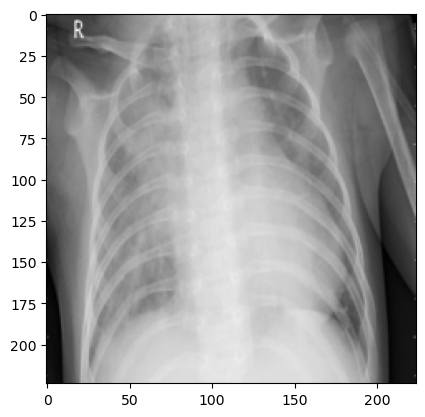

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 첫 번째 배치를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 배치에서 첫 번째 이미지 확인
print(f"이미지 텐서 크기: {images[0].shape}")  # 이미지의 크기 출력
print(f"첫 번째 이미지의 라벨: {labels[0]}")  # 첫 번째 이미지의 라벨 출력

# 이미지 시각화
def imshow(img):
    img = img.numpy()  # 텐서를 넘파이 배열로 변환
    img = img[0]  # 흑백 이미지를 위해 첫 번째 채널만 가져옴
    plt.imshow(img, cmap='gray')  # 흑백 이미지를 위한 'gray' 컬러맵 사용
    plt.show()

# 첫 번째 이미지 시각화
imshow(images[0])


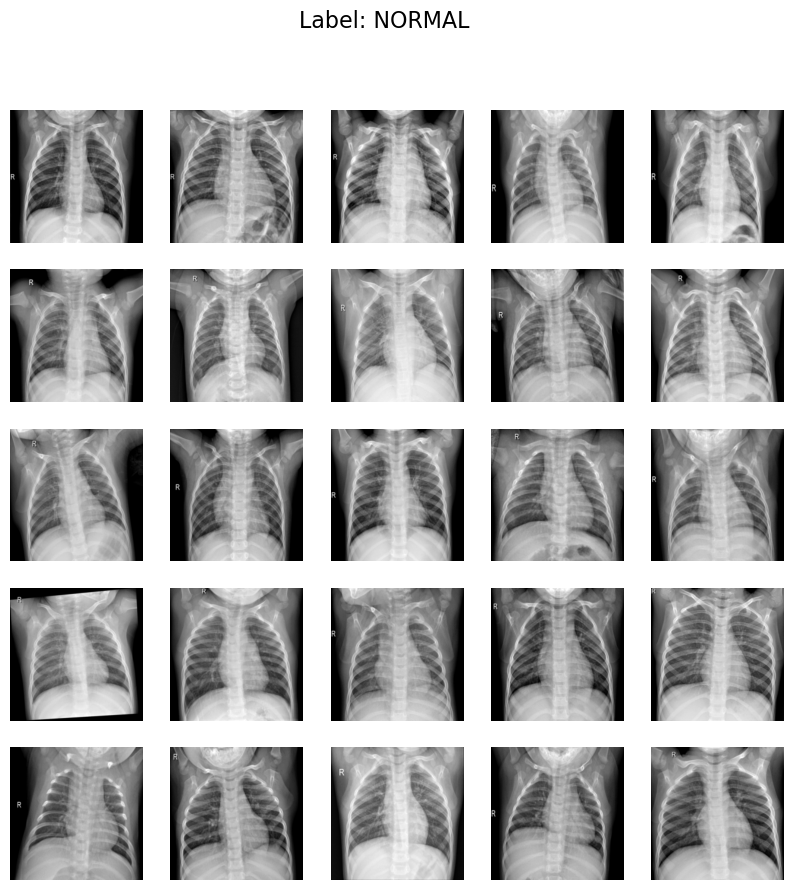

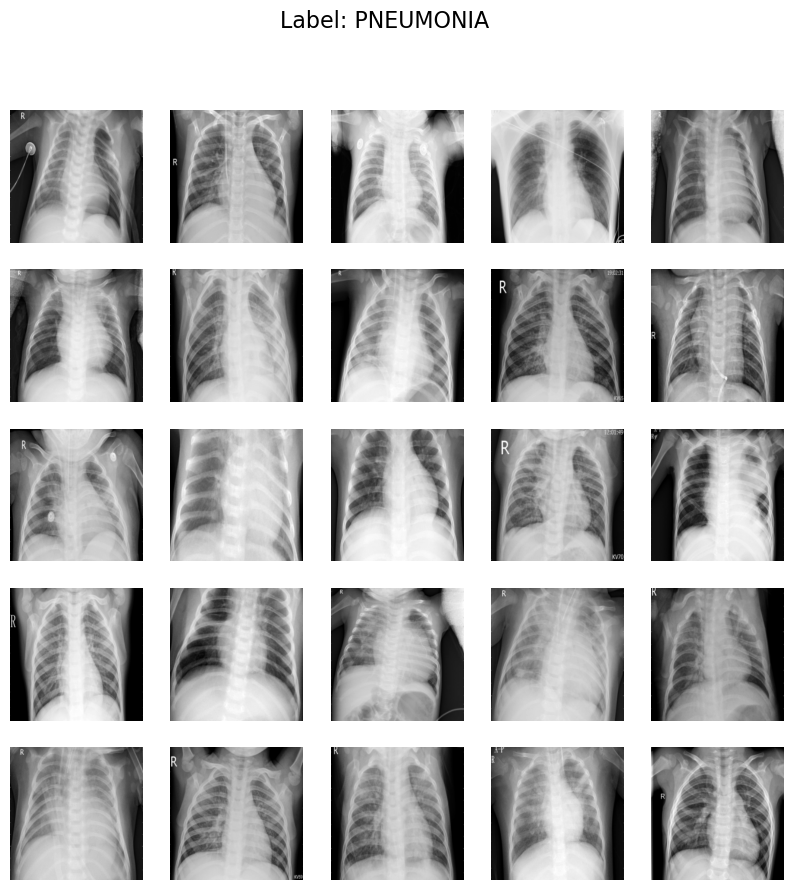

In [6]:
import matplotlib.pyplot as plt

# 데이터셋에서 라벨별로 이미지를 샘플링하는 함수
def plot_images_by_label(loader, label_to_filter, num_images=25):
    filtered_images = []
    filtered_labels = []
    
    # 데이터 로더에서 이미지를 반복하여 필요한 라벨의 이미지를 모음
    for images, labels in loader:
        for i in range(len(labels)):
            if labels[i] == label_to_filter:
                filtered_images.append(images[i])
                filtered_labels.append(labels[i])
            if len(filtered_images) >= num_images:
                break
        if len(filtered_images) >= num_images:
            break
    
    # 이미지 시각화
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(f"Label: {'NORMAL' if label_to_filter == 0 else 'PNEUMONIA'}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        img = filtered_images[i].numpy()[0]  # 흑백 이미지
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

# 노말 이미지 25개 시각화
plot_images_by_label(train_loader, label_to_filter=0, num_images=25)

# 폐렴 이미지 25개 시각화
plot_images_by_label(train_loader, label_to_filter=1, num_images=25)
